In [1]:
import random
import copy
from scipy.stats import norm
import numpy as np
import math
import argparse

import sys
import os
import time
import yaml
import numpy as np
import random

SEED = 1234
#SEED = 1
# Get the current working directory of the notebook
current_directory = os.getcwd()

# Get the parent directory
parent_directory = os.path.dirname(current_directory)

# Add the parent directory to the system path
sys.path.append(parent_directory)
import concurrent.futures
#import multiprocessing as mp
import pickle

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

from agent.q_learning_agent import ValueIteration
from mdp import gridworld_env_layout
from mdp import gridworld_env
from data_generation.generate_data import (generate_random_trajectory,
                                           simulate_human_estop_v2)
                                            #simulate_improvement_feedback_for_feasible_region)
from utils.mdp_generator import generate_random_gridworld_envs
from mdp.gridworld_env_layout import GridWorldMDPFromLayoutEnv
# Fixing Seeds
random.seed(SEED)  # Fix Python's built-in random module
np.random.seed(SEED)  # Fix NumPy
os.environ['PYTHONHASHSEED'] = str(SEED)  # Ensure deterministic hashing

In [2]:
os.cpu_count()

16

## Loading env

In [3]:
import numpy as np

# Array of 2D feature weight vectors
feature_weights_list = np.array([[-5, -1],
                                [-4, -2],
                                [-7, -5],
                                [-10, -1],
                                [-1, 3],
                                [-6, 2],
                                [-0.9701425, 0.24253563]])

# Normalize vectors by L2 norm
norms = np.linalg.norm(feature_weights_list, axis=1)
feature_weights_list = feature_weights_list / norms[:, np.newaxis]

# Map colors to feature vectors
color_to_feature_map = {
    "red": [1, 0],
    "blue": [0, 1]
}

#Define 2x3 grid with color-based features
# custom_grid_features = np.array([
#     ["blue", "red", "blue"],
#     ["blue", "blue", "blue"],
#     ["blue", "red", "blue"]
# ])
# custom_grid_features = np.array([
#     ["blue", "blue"],
#     ["blue", "red"],
#     ["blue", "blue"]
# ])
# custom_grid_features = np.array([
#     ["blue", "red", "blue"],
#     ["blue", "blue", "blue"]
# ])
# custom_grid_features = np.array([
#     ["blue", "blue", "red","blue","blue"],
#     ["red", "blue", "blue","blue","red"],
#     ["blue", "red", "blue","red","blue"],
#     ["red", "blue", "blue","blue","red"],
#     ["blue", "blue", "red","blue","blue"]
# ])
# Set max horizon for trajectories to twice the MDP grid size (rows * cols),
# ensuring sufficient exploration while limiting trajectory length for computational efficiency.
MAX_HORIZON = 2 * 6
Terminal_State = 2
TRUE_REWARD = feature_weights_list[-1]
#TRUE_REWARD = feature_weights_list[0]
# Initialize gridworld environment
# No extra features for terminal state, just terminates the trajectory
envs, meta = generate_random_gridworld_envs(
    n_envs=10,
    rows=2, cols=3,
    color_to_feature_map={"red":[1.0,0.0], "blue":[0.0,1.0]},
    palette=("red","blue"),
    p_color_range={"red":(0.2,0.6), "blue":(0.4,0.8)},
    terminal_policy=dict(kind="random_k", k_min=0, k_max=1, p_no_terminal=0.1),
    gamma_range=(0.98, 0.995),
    noise_prob_range=(0.0, 0.0),
    w_mode="fixed",
    W_fixed=TRUE_REWARD,
    seed=SEED,
    GridEnvClass=GridWorldMDPFromLayoutEnv,
)
env = envs[0]

# env = gridworld_env_layout.GridWorldMDPFromLayoutEnv(
#     gamma=0.99,
#     color_to_feature_map=color_to_feature_map,
#     layout=custom_grid_features,
#     custom_feature_weights=TRUE_REWARD,
#     terminal_states=[Terminal_State]
# )
# env = gridworld_env.NoisyLinearRewardFeaturizedGridWorldEnv(
#     gamma=0.99,
#     color_to_feature_map=color_to_feature_map,
#     grid_features=custom_grid_features,
#     custom_feature_weights=feature_weights_list[-1],
#     # custom_feature_weights=feature_weights_list[0],
#     terminal_states=[Terminal_State])


In [4]:
envs

In [5]:
envs[1].layout

[['red', 'red', 'blue'], ['red', 'blue', 'blue']]

In [6]:
feature_weights_list[0]

array([-0.98058068, -0.19611614])

### Removing redundant constraints using linear programming

In [7]:
from scipy.optimize import linprog

def is_redundant_constraint(h, H, epsilon=0.0001):
    #we have a constraint c^w >= 0 we want to see if we can minimize c^T w and get it to go below 0
    # if not then this constraint is satisfied by the constraints in H, if we can, then we need to add c back into H
    #Thus, we want to minimize c^T w subject to Hw >= 0
    #First we need to change this into the form min c^T x subject to Ax <= b
    #Our problem is equivalent to min c^T w subject to  -H w <= 0
    H = np.array(H) #just to make sure
    m,_ = H.shape

    b = np.zeros(m)
    sol = linprog(h, A_ub=-H, b_ub = b, bounds=(-1,1), method='highs' )
    if sol['status'] != 0:
        print("trying interior point method")
        sol = linprog(h, A_ub=-H, b_ub = b, bounds=(-1,1) )

    if sol['status'] != 0:
        print("LP NOT SOLVABLE")
        print("IGNORING ERROR FOR NOW!!!!!!!!!!!!!!!!!!!")
        return False #let's be safe and assume it's necessary...
    elif sol['fun'] < -epsilon: #if less than zero then constraint is needed to keep c^T w >=0
        return False
    else: #redundant since without constraint c^T w >=0
        return True

def remove_redundant_constraints(halfspaces, epsilon = 0.0001):
    """Return a new array with all redundant halfspaces removed.

       Parameters
       -----------
       halfspaces : list of halfspace normal vectors such that np.dot(halfspaces[i], w) >= 0 for all i

       epsilon : numerical precision for determining if redundant via LP solution

       Returns
       -----------
       list of non-redundant halfspaces
    """
    #for each row in halfspaces, check if it is redundant
    #num_vars = len(halfspaces[0]) #size of weight vector
    non_redundant_halfspaces = []
    halfspaces_to_check = halfspaces
    for i,h in enumerate(halfspaces):
        #print("\nchecking", h)
        halfspaces_lp = [h for h in non_redundant_halfspaces] + [h for h in halfspaces_to_check[1:]]
        halfspaces_lp = np.array(halfspaces_lp)

        if not is_redundant_constraint(h, halfspaces_lp, epsilon):
            #keep h
            #print("not redundant")
            non_redundant_halfspaces.append(h)
        else:
            pass
            ##print("redundant")

        halfspaces_to_check = halfspaces_to_check[1:]
    return non_redundant_halfspaces
#non_redundant_vecs = remove_redundant_constraints(unique_normalized_vectors, epsilon = 0.0001)

### Generating random trajectories with different starting states in the given MDP

In [8]:
# num_samples = 1000000
# num_workers = mp.cpu_count()

# # Parallel generation of random trajectories
# def generate_one_trajectory(_):
#     return generate_random_trajectory(env, max_horizon=10, fixed_start=False)

# # Generate trajectories in parallel
# with mp.Pool(processes=num_workers) as pool:
#     random_trajs = pool.map(generate_one_trajectory, range(num_samples))

# # Optionally: Save results
# with open("random_trajs.pkl", "wb") as f:
#     pickle.dump(random_trajs, f)
num_samples = 10
#num_samples = 10
num_workers = os.cpu_count()
# Parallel generation of random trajectories
# def generate_one_trajectory(_):
#     return generate_random_trajectory(env, max_horizon=MAX_HORIZON, fixed_start=False, row=rows, col=cols)

def generate_one_trajectory(_):
    return generate_random_trajectory(env, max_horizon=MAX_HORIZON, fixed_start=False)

# Generate trajectories using concurrent.futures
with concurrent.futures.ThreadPoolExecutor(max_workers=num_workers) as executor:
    random_trajs = list(executor.map(generate_one_trajectory, range(num_samples)))

# Optionally: Save results
with open("random_trajs.pkl", "wb") as f:
    pickle.dump(random_trajs, f)

In [9]:
file = open('random_trajs.pkl', 'rb')
random_trajs = pickle.load(file)
file.close()

### Generating E-stop feedback from generated random trajectories

In [10]:
#Parallel simulation of human estops
# def simulate_one_estop(traj):
#     return simulate_human_estop_v2(env, traj, beta=100, gamma=0.99)

# # Simulate estops in parallel
# with mp.Pool(processes=num_workers) as pool:
#     estops = pool.map(simulate_one_estop, random_trajs)

# with open("estops_feedbacks.pkl", "wb") as f:
#     pickle.dump(estops, f)
#Parallel simulation of human estops
num_workers = os.cpu_count()
def simulate_one_estop(traj):
    return simulate_human_estop_v2(env, traj, beta=100, gamma=0.99)

# Simulate estops using concurrent.futures
with concurrent.futures.ThreadPoolExecutor(max_workers=num_workers) as executor:
    estops = list(executor.map(simulate_one_estop, random_trajs))

with open("estops_feedbacks.pkl", "wb") as f:
    pickle.dump(estops, f)

### Finding unique vectors in E-stops

In [11]:
file = open('estops_feedbacks.pkl', 'rb')
estops = pickle.load(file)
file.close()

normalized_unique_vectors_estops = []

seen = set()

for traj, t in estops:
    # Compute features up to t
    features_up_to_t = [env.get_state_feature(s) for s, _ in traj[:t+1]]
    sum_feat_up_to_t = np.sum(features_up_to_t, axis=0)

    # Compute features for full trajectory
    full_traj_features = [env.get_state_feature(s) for s, _ in traj]
    traj_feat = np.sum(full_traj_features, axis=0)

    # Difference
    diff = sum_feat_up_to_t - traj_feat

    # Normalize (L2 norm)
    norm = np.linalg.norm(diff)
    if norm == 0:
        normalized = np.zeros_like(diff)
    else:
        normalized = diff / norm

    key = tuple(np.round(normalized, decimals=6))  # rounding to avoid float precision issues
    if key not in seen:
        seen.add(key)
        normalized_unique_vectors_estops.append(normalized)

normalized_unique_vectors_estops = remove_redundant_constraints(normalized_unique_vectors_estops, epsilon=0.0001)

# Optionally: Save results
with open("normalized_unique_vectors_estops.pkl", "wb") as f:
    pickle.dump(normalized_unique_vectors_estops, f)

### Visualizing Feasible region of E-stops

C:\Users\chang zong wu\AppData\Local\Temp\ipykernel_9296\371715993.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('tab10', num_constraints)  # tab10 or any other categorical colormap


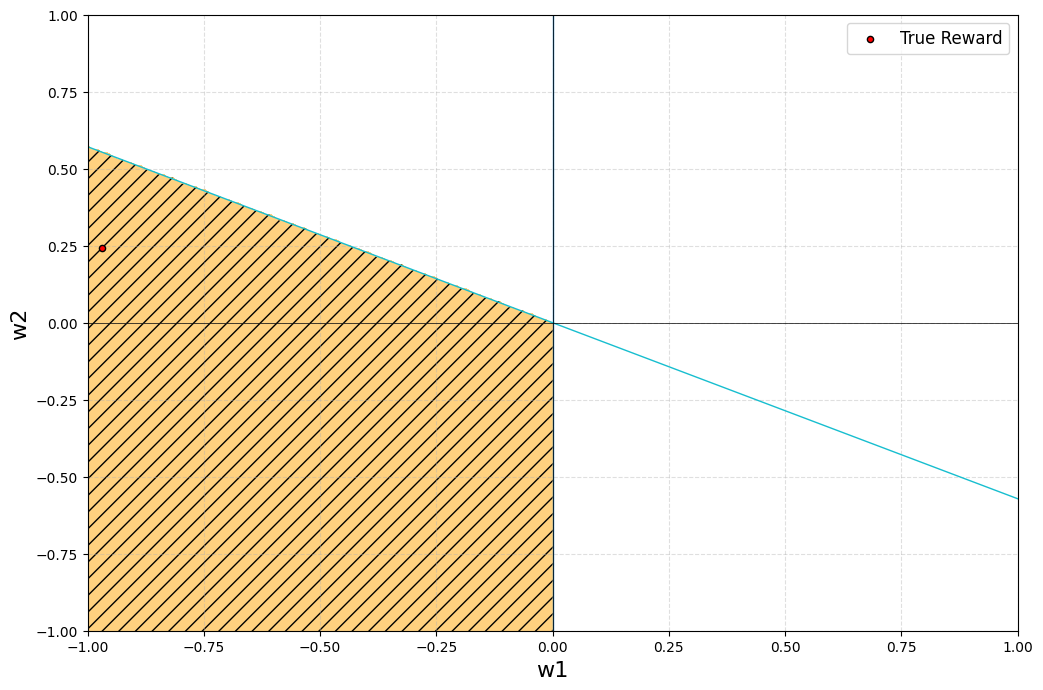

In [12]:
xs = []

for i in normalized_unique_vectors_estops:
    xs.append(list(i))

# Plot setup
plt.figure(figsize=(12, 8))

num_constraints = len(xs)
colormap = cm.get_cmap('tab10', num_constraints)  # tab10 or any other categorical colormap
colors = [colormap(i) for i in range(num_constraints)]

x1 = np.linspace(-2, 2, 100)

# Plot constraint lines
for i, point in enumerate(xs):
    if np.all(point == 0):  # Skip [0, 0]
        continue
    if abs(point[1]) > 1e-10:  # Non-vertical line
        x2 = -(point[0] / point[1]) * x1
        #plt.plot(x1, x2, color=colors[i], linestyle='-', linewidth=4, label=f'Constraint {i+1}')
        plt.plot(x1, x2, color=colors[i], linestyle='-', linewidth=1)
    else:  # Vertical line
        #plt.axvline(x=0, color=colors[i], linestyle='-', linewidth=4, label=f'Constraint {i+1}')
        plt.axvline(x=0, color=colors[i], linestyle='-', linewidth=1)

# Feasible region
x1_grid, x2_grid = np.meshgrid(np.linspace(-2, 2, 400), np.linspace(-2, 2, 400))
feasible = np.ones_like(x1_grid, dtype=bool)

for i, point in enumerate(xs):
    if np.all(point == 0):
        continue
    constraint = point[0] * x1_grid + point[1] * x2_grid >= 0
    feasible &= constraint

# Plot feasible region with hatch
plt.contourf(x1_grid, x2_grid, feasible, levels=[0.5, 1], colors='orange', alpha=0.5, hatches=['//'])

true_reward = TRUE_REWARD
plt.scatter(true_reward[0], true_reward[1], color='red', s=20, edgecolors='black', zorder=5, label='True Reward')


# Axes and labels
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.grid(True, linestyle="--", alpha=0.4)
plt.xlabel('w1', fontsize=16)
plt.ylabel('w2', fontsize=16)
plt.legend(fontsize=12)
plt.xlim(-1, 1)
plt.ylim(-1, 1)
#plt.savefig("estop_feasible_region_non_fixed.jpeg", dpi=2000, bbox_inches='tight')
plt.show()

In [13]:
print(f"Total feasible points: {np.sum(feasible)}")
print(f"Feasible region exists: {np.any(feasible)}")

Total feasible points: 51428
Feasible region exists: True


## Generating pairwise comparisons

In [14]:
import random
from itertools import combinations

def generate_random_pairwise_comparisons(env, trajectories, num_comparisons=10):
    """
    Randomly samples a fixed number of pairwise comparisons between trajectories.

    Args:
        env: The GridWorld environment.
        trajectories (list): List of pre-generated trajectories (each a list of (state, action) tuples).
        num_comparisons (int): Number of comparisons to return.

    Returns:
        List of tuples: (better_trajectory, worse_trajectory)
    """
    total_possible = len(trajectories) * (len(trajectories) - 1) // 2
    if num_comparisons > total_possible:
        raise ValueError(f"Requested {num_comparisons} comparisons, but only {total_possible} unique pairs possible.")

    comparisons = []
    used_pairs = set()

    while len(comparisons) < num_comparisons:
        i, j = random.sample(range(len(trajectories)), 2)
        pair_key = tuple(sorted((i, j)))

        if pair_key in used_pairs:
            continue
        used_pairs.add(pair_key)
        #print(f"Comparing trajectories {i} and {j}")
        traj_i = trajectories[i]
        traj_j = trajectories[j]

        reward_i = sum(env.compute_reward(s) for s, _ in traj_i)
        reward_j = sum(env.compute_reward(s) for s, _ in traj_j)

        if reward_i > reward_j:
            comparisons.append((traj_i, traj_j))
        elif reward_j > reward_i:
            comparisons.append((traj_j, traj_i))
        # skip ties
    print(f"Generated {len(comparisons)} pairwise comparisons from {len(trajectories)} trajectories")
    return comparisons

# comparisons = generate_random_pairwise_comparisons(env, random_trajs, num_comparisons=1000000)
# #comparisons = generate_random_pairwise_comparisons(env, random_trajs, num_comparisons=10)
# # Optionally: Save results
# with open("comparisons.pkl", "wb") as f:
#     pickle.dump(comparisons, f)

In [15]:
def generate_all_pairwise_comparisons(env, trajectories, num_comparisons=None):
    """
    Generate pairwise comparisons between all possible pairs of trajectories
    without storing all combinations in memory at once.

    Args:
        env: The GridWorld environment.
        trajectories (list): List of pre-generated trajectories.
        num_comparisons (int, optional): Maximum number of comparisons to return.
                                        If None, generate all possible comparisons.

    Returns:
        List of tuples: (better_trajectory, worse_trajectory)
    """
    import random

    comparisons = []
    total_trajectories = len(trajectories)
    # Generate all pairs in memory-efficient way
    # This is used when num_comparisons is None or >= total_possible
    for i in range(total_trajectories):
        for j in range(i+1, total_trajectories):  # Start from i+1 to avoid duplicates
            traj_i = trajectories[i]
            traj_j = trajectories[j]
            #print(f"Comparing trajectories {i} and {j}")
            reward_i = sum(env.compute_reward(s) for s, _ in traj_i)
            reward_j = sum(env.compute_reward(s) for s, _ in traj_j)

            if reward_i > reward_j:
                comparisons.append((traj_i, traj_j))
            elif reward_j > reward_i:
                comparisons.append((traj_j, traj_i))

    print(f"Generated {len(comparisons)} pairwise comparisons from {len(trajectories)} trajectories")
    return comparisons

comparisons = generate_random_pairwise_comparisons(env, random_trajs, num_comparisons=10)
#comparisons = generate_all_pairwise_comparisons(env, random_trajs, num_comparisons=10000)
# Optionally: Save results
with open("comparisons.pkl", "wb") as f:
    pickle.dump(comparisons, f)

Generated 10 pairwise comparisons from 10 trajectories


### Finding unique vectors of pairwise comparisons

In [16]:
# file = open('comparisons_3M_non_fixed_2.pkl', 'rb')
# comparisons = pickle.load(file)
# file.close()

def extract_unique_normalized_comparison_diffs(env, comparisons):
    """
    For each (preferred, other) trajectory pair, compute the normalized feature difference
    and return only unique differences.

    Args:
        env: environment with `get_state_feature(state)` method.
        comparisons: list of (preferred_traj, other_traj) pairs.

    Returns:
        List of unique np.array normalized difference vectors.
    """
    seen = set()
    unique_vectors = []

    for preferred, other in comparisons:
        preferred_feats = [env.get_state_feature(s) for s, _ in preferred]
        other_feats = [env.get_state_feature(s) for s, _ in other]

        preferred_sum = np.sum(preferred_feats, axis=0)
        other_sum = np.sum(other_feats, axis=0)

        diff = preferred_sum - other_sum
        norm = np.linalg.norm(diff)

        normalized = diff / norm if norm != 0 else np.zeros_like(diff)
        key = tuple(np.round(normalized, decimals=6))  # use rounding for stable hashing

        if key not in seen:
            seen.add(key)
            unique_vectors.append(normalized)

    return unique_vectors


# Some pairwise comparisons in the 2 * 3 MDP where I want to include them
# If you change the MDP layout, weights etc you need  to double check these preferences to make sure they are valid
# pairwise_comparisons = [([(0,1), (3,3), (4,3), (5,None)], [(0,1), (3,0), (0,1), (3,0)]),
#                     ([(0,1), (3,3), (4,3), (5,None)], [(0,3), (1,3), (2,1), (5,None)]),
#                     ([(0,1), (3,3), (4,3), (5,None)], [(0,3), (1,1), (4,3), (5,None)])]
pairwise_comparisons = []

normalized_unique_vectors_comparisons = extract_unique_normalized_comparison_diffs(env, comparisons+pairwise_comparisons)

normalized_unique_vectors_comparisons = remove_redundant_constraints(normalized_unique_vectors_comparisons, epsilon=0.0001)

# Optionally: Save results
with open("normalized_unique_vectors_comparisons.pkl", "wb") as f:
    pickle.dump(normalized_unique_vectors_comparisons, f)

### Visualizing pairwise comparisons feasible region

C:\Users\chang zong wu\AppData\Local\Temp\ipykernel_9296\3578792682.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('tab10', num_constraints)  # tab10 or any other categorical colormap


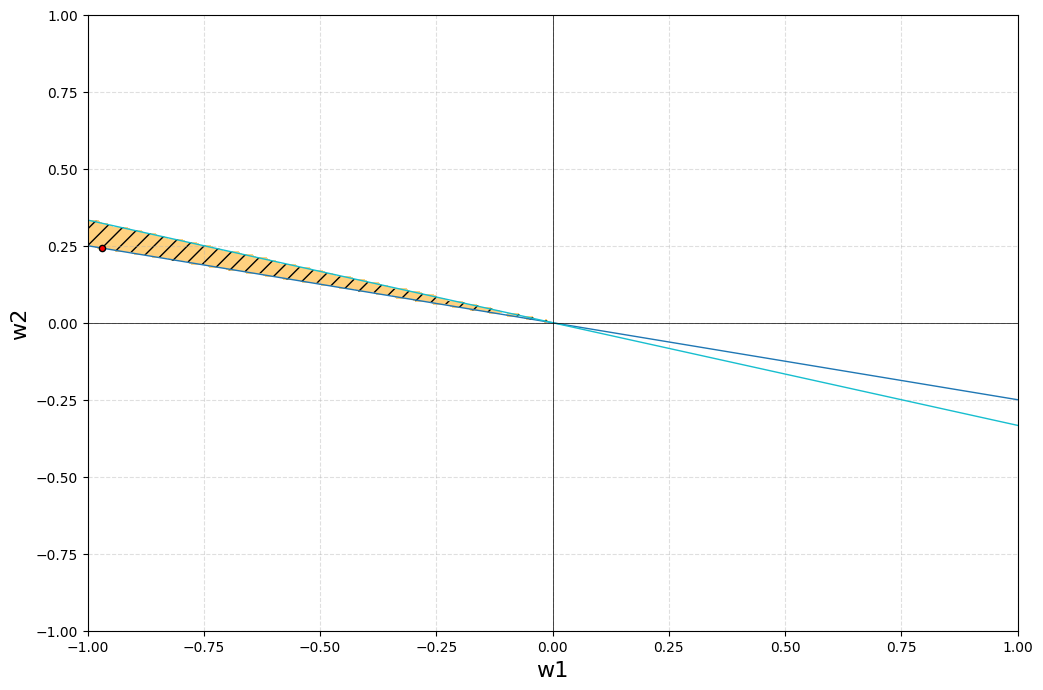

In [17]:
file = open('normalized_unique_vectors_comparisons.pkl', 'rb')

normalized_unique_vectors_comparisons = pickle.load(file)
file.close()
xs = []
for i in normalized_unique_vectors_comparisons:
    xs.append(list(i))

# Plot setup
plt.figure(figsize=(12, 8))
num_constraints = len(xs)
colormap = cm.get_cmap('tab10', num_constraints)  # tab10 or any other categorical colormap
colors = [colormap(i) for i in range(num_constraints)]

# '#1f77b4', '#ff7f0e', '#2ca02c'
x1 = np.linspace(-2, 2, 100)

# Plot constraint lines
for i, point in enumerate(xs):

    if abs(point[1]) > 1e-10:  # Non-vertical line
        x2 = -(point[0] / point[1]) * x1
        plt.plot(x1, x2, color=colors[i], linestyle='-', linewidth=1, label=f'Constraint {i+1}')
    else:  # Vertical line
        plt.axvline(x=0, color=colors[i], linestyle='-', linewidth=1, label=f'Constraint {i+1}')

# Feasible region
x1_grid, x2_grid = np.meshgrid(np.linspace(-2, 2, 400), np.linspace(-2, 2, 400))
feasible = np.ones_like(x1_grid, dtype=bool)

for i, point in enumerate(xs):
    if np.all(point == 0):
        continue
    constraint = point[0] * x1_grid + point[1] * x2_grid >= 0
    feasible &= constraint

# Plot feasible region with hatch
plt.contourf(x1_grid, x2_grid, feasible, levels=[0.5, 1], colors='orange', alpha=0.5, hatches=['//'])

true_reward = TRUE_REWARD
plt.scatter(true_reward[0], true_reward[1], color='red', s=20, edgecolors='black', zorder=5, label='True Reward')


# Axes and labels
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.grid(True, linestyle="--", alpha=0.4)
plt.xlabel('w1', fontsize=16)
plt.ylabel('w2', fontsize=16)
#plt.legend(fontsize=12)
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.savefig("pairwise_comparison_feasible_region_non_fixed.pdf", dpi=3000, bbox_inches='tight')
plt.show()


In [18]:
print(f"Total feasible points: {np.sum(feasible)}")
print(f"Feasible region exists: {np.any(feasible)}")

Total feasible points: 1685
Feasible region exists: True


## Generating correction feedback just based on same start

In [19]:
import numpy as np
import random

def generate_random_trajectory(env, start_state, trajectory_length):
    """
    Generate a random trajectory starting from the specified state and with the specified length.

    Args:
        env: The environment object.
        start_state: The state from which the trajectory should start.
        trajectory_length: The length of the trajectory to generate.

    Returns:
        list of (state_index, action) tuples representing the trajectory.
    """
    trajectory = []
    state = start_state
    terminal_states = env.terminal_states  # List of terminal states as indices

    for step in range(trajectory_length):
        if state in terminal_states:
            trajectory.append((state, None))  # Append terminal state with None action
            break  # Stop if terminal state is reached

        # Choose a random action uniformly
        action = np.random.choice(env.num_actions)

        # Sample the next state based on transition probabilities
        next_state = np.random.choice(env.num_states, p=env.transitions[state][action])

        trajectory.append((state, action))
        state = next_state

    return trajectory

def simulate_improvement_from_random_trajs(env, pre_generated_trajectories, num_random_trajs=5):
    """
    For each pre-generated trajectory, generate a set of new random trajectories starting from the same state,
    and compare their rewards. Select the trajectory with the highest reward as the improved trajectory.

    Args:
        env: The environment object.
        pre_generated_trajectories: List of pre-generated trajectories.
        num_random_trajs: The number of random trajectories to generate for comparison.

    Returns:
        List of tuples of paired trajectories: (improved_trajectory, original_trajectory)
    """
    def evaluate_trajectory(traj):
        """Compute total reward of a trajectory."""
        return sum(env.compute_reward(s) for s, _ in traj)

    paired_trajectories = []

    for traj in pre_generated_trajectories:
        # Extract the start state of the trajectory (start state is the first state of the trajectory)
        start_state = traj[0][0]

        # Generate a set of random trajectories from the same start state and same length
        random_trajectories = [generate_random_trajectory(env, start_state, len(traj)) for _ in range(num_random_trajs)]

        # Compare the rewards of the original and all generated random trajectories
        original_return = evaluate_trajectory(traj)

        # Select the random trajectory with the highest reward
        max_random_return = float('-inf')
        best_random_traj = None

        for new_traj in random_trajectories:
            new_return = evaluate_trajectory(new_traj)
            if new_return > max_random_return:
                max_random_return = new_return
                best_random_traj = new_traj

        # Select the trajectory with the highest reward
        if max_random_return > original_return:
            paired_trajectories.append((best_random_traj, traj))  # The best random trajectory is the improvement
        else:
            paired_trajectories.append((traj, best_random_traj))  # The original trajectory is better or equal

    return paired_trajectories

In [20]:
improvements_same_start = simulate_improvement_from_random_trajs(env, random_trajs)

In [21]:
#file = open('improvement_v3_3M_q_val_non_fixed.pkl', 'rb')
improvements = improvements_same_start
#file.close()
if not improvements_same_start:
    print("WARNING: No improvement pairs were generated!")
normalized_unique_vectors_improvements = []
seen = set()

for improved, other in improvements:
    # Compute features up to t

    improved_traj = [env.get_state_feature(s) for s, _ in improved]
    sum_feat_improved = np.sum(improved_traj, axis=0)

    # Compute features for full trajectory
    other_traj = [env.get_state_feature(s) for s, _ in other]
    sum_feat_other = np.sum(other_traj, axis=0)

    # Difference
    diff = sum_feat_improved - sum_feat_other

    # Normalize (L2 norm)
    norm = np.linalg.norm(diff)
    if norm == 0:
        normalized = np.zeros_like(diff)
    else:
        normalized = diff / norm

    # Convert to tuple for hashing and check uniqueness
    key = tuple(np.round(normalized, decimals=6))  # rounding to avoid float precision issues
    if key not in seen:
        seen.add(key)
        normalized_unique_vectors_improvements.append(normalized)

normalized_unique_vectors_improvements = remove_redundant_constraints(normalized_unique_vectors_improvements, epsilon=0.0001)
# Optionally: Save results
with open("normalized_unique_vectors_improvements.pkl", "wb") as f:
    pickle.dump(normalized_unique_vectors_improvements, f)

C:\Users\chang zong wu\AppData\Local\Temp\ipykernel_9296\988177688.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('tab10', num_constraints)  # tab10 or any other categorical colormap


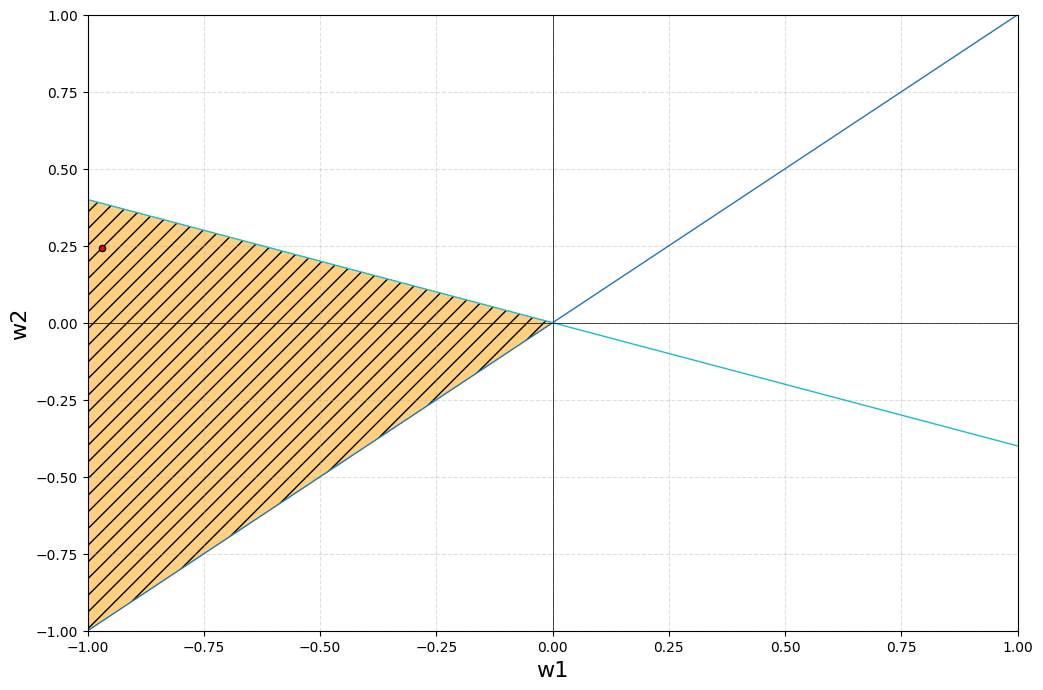

In [22]:
# file = open('normalized_unique_vectors_improvements_q_val_non_fixed_same_start_2.pkl', 'rb')
# normalized_unique_vectors_improvements = pickle.load(file)
# file.close()

xs = []

for i in normalized_unique_vectors_improvements:
    xs.append(list(i))

xs = xs

# Plot setup
plt.figure(figsize=(12, 8))
num_constraints = len(xs)
colormap = cm.get_cmap('tab10', num_constraints)  # tab10 or any other categorical colormap
colors = [colormap(i) for i in range(num_constraints)]

# '#1f77b4', '#ff7f0e', '#2ca02c'
x1 = np.linspace(-1, 1, 4000)

# Plot constraint lines
for i, point in enumerate(xs):

    if abs(point[1]) > 1e-10:  # Non-vertical line
        x2 = -(point[0] / point[1]) * x1
        plt.plot(x1, x2, color=colors[i], linestyle='-', linewidth=1, label=f'Constraint {i+1}')
    else:  # Vertical line
        plt.axvline(x=0, color=colors[i], linestyle='-', linewidth=1, label=f'Constraint {i+1}')

# Feasible region
x1_grid, x2_grid = np.meshgrid(np.linspace(-1, 1, 8000), np.linspace(-1, 1, 8000))
feasible = np.ones_like(x1_grid, dtype=bool)

for i, point in enumerate(xs):
    if np.all(point == 0):
        continue
    constraint = point[0] * x1_grid + point[1] * x2_grid >= 0
    feasible &= constraint

# Plot feasible region with hatch

#plt.contourf(x1_grid, x2_grid, feasible, levels=[0.5, 1], colors='lavender', alpha=0.5)
plt.contourf(x1_grid, x2_grid, feasible, levels=[0.5, 1], colors='orange', alpha=0.5, hatches=['//'])
#plt.scatter(x1_grid[feasible], x2_grid[feasible], color='blue', s=1, label='Feasible Points')

true_reward = TRUE_REWARD
plt.scatter(true_reward[0], true_reward[1], color='red', s=20, edgecolors='black', zorder=5, label='True Reward')


# Axes and labels
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.grid(True, linestyle="--", alpha=0.4)
plt.xlabel('w1', fontsize=16)
plt.ylabel('w2', fontsize=16)
#plt.legend(fontsize=12)
plt.xlim(-1, 1)
plt.ylim(-1, 1)
#plt.savefig("improvement_feasible_region_non_fixed_same_start.pdf", dpi=2000, bbox_inches='tight')
plt.show()

In [23]:
print(f"Total feasible points: {np.sum(feasible)}")
print(f"Feasible region exists: {np.any(feasible)}")

Total feasible points: 11202000
Feasible region exists: True


## Generating demonstration

In [24]:
import numpy as np
import random
#from multiprocessing import Pool, cpu_count
from concurrent.futures import ThreadPoolExecutor
from functools import partial

q_values = ValueIteration(env).get_q_values()

# Function to get the intended next state
def get_intended_next_state(env, state, action):
    probs = env.transitions[state][action]
    return np.random.choice(list(range(env.num_states)), p=probs)

# Function to generate an optimal trajectory
def generate_optimal_trajectory(env, start_state, q_values):
    if start_state in env.terminal_states:
        return [start_state], []  # Return only the terminal state with no actions

    current_state = start_state
    states = [current_state]
    actions = []
    terminal_states = set(env.terminal_states)
    max_steps = 100

    for _ in range(max_steps):
        if current_state in terminal_states:
            break
        max_q = np.max(q_values[current_state])
        epsilon = 1e-10
        optimal_actions = [a for a in range(env.get_num_actions()) if abs(q_values[current_state][a] - max_q) < epsilon]
        if not optimal_actions:
            break
        action = np.random.choice(optimal_actions)
        actions.append(action)
        current_state = get_intended_next_state(env, current_state, action)
        states.append(current_state)

    return states, actions

# Function to generate a random trajectory
def generate_random_trajectory(env, start_state):
    current_state = start_state
    states = [current_state]
    actions = []
    terminal_states = set(env.terminal_states)
    max_steps = 100

    for _ in range(max_steps):
        if current_state in terminal_states:
            break
        action = random.randrange(env.get_num_actions())
        actions.append(action)
        current_state = get_intended_next_state(env, current_state, action)
        states.append(current_state)

    return states, actions

# Function to compute sum of features for a trajectory
def compute_feature_sum(env, states):
    feature_sum = np.zeros(env.num_features)
    for t, state in enumerate(states):
        #feature_sum += (env.gamma)**t *( env.get_state_feature(state))
        feature_sum += ( env.get_state_feature(state))
    return feature_sum

# Wrapper function to generate multiple optimal trajectories for a start state
def generate_multiple_optimal_trajectories_for_state(start_state, env, q_values, num_trajectories):
    trajectories = []
    for _ in range(num_trajectories):
        states, actions = generate_optimal_trajectory(env, start_state, q_values)
        trajectories.append((states, actions))
    return start_state, trajectories

# Wrapper function to generate multiple random trajectories for a start state
def generate_multiple_random_trajectories_for_state(start_state, env, num_trajectories):
    trajectories = []
    for _ in range(num_trajectories):
        states, actions = generate_random_trajectory(env, start_state)
        trajectories.append((states, actions))
    return start_state, trajectories

# Function to compute difference vectors for a chunk of optimal trajectories
def compute_difference_vectors_for_chunk(chunk_info, start_state, optimal_trajectories, random_trajectories, env):
    start_idx, end_idx = chunk_info
    diff_vectors = []
    for i in range(start_idx, end_idx):
        opt_states, _ = optimal_trajectories[start_state][i]
        opt_feature_sum = compute_feature_sum(env, opt_states)
        for j in range(len(random_trajectories[start_state])):
            rand_states, _ = random_trajectories[start_state][j]
            rand_feature_sum = compute_feature_sum(env, rand_states)

            diff_vector = opt_feature_sum - rand_feature_sum
            if np.dot(env.feature_weights, diff_vector) > 0:
                diff_vectors.append(diff_vector)


    return diff_vectors


num_optimal_trajectories = 5
num_random_trajectories = 5
num_states = env.get_num_states()
terminal_states = env.terminal_states
print(terminal_states)
non_terminal_states = [s for s in range(num_states) if s not in terminal_states]

# Determine number of processes (use CPU count, but cap to avoid overhead)
# num_processes = cpu_count()
num_processes = os.cpu_count()
print(f"Using {num_processes} processes for trajectory generation")

# Parallelize optimal trajectory generation
# with Pool(processes=num_processes) as pool:
#     optimal_results = pool.starmap(
#         generate_multiple_optimal_trajectories_for_state,
#         [(state, env, q_values, num_optimal_trajectories) for state in non_terminal_states]
#     )
with ThreadPoolExecutor(max_workers=num_processes) as executor:
    futures = [executor.submit(generate_multiple_optimal_trajectories_for_state,
                              state, env, q_values, num_optimal_trajectories)
               for state in non_terminal_states]
    optimal_results = [future.result() for future in futures]
optimal_trajectories = {state: traj for state, traj in optimal_results}
# print(optimal_trajectories.keys())
# print(optimal_trajectories[0][0])

# print(len(optimal_trajectories[0]))

# Parallelize random trajectory generation
# with Pool(processes=num_processes) as pool:
#     random_results = pool.starmap(
#         generate_multiple_random_trajectories_for_state,
#         [(state, env, num_random_trajectories) for state in non_terminal_states]
#     )
with ThreadPoolExecutor(max_workers=num_processes) as executor:
    futures = [executor.submit(generate_multiple_random_trajectories_for_state,
                              state, env, num_random_trajectories)
               for state in non_terminal_states]
    random_results = [future.result() for future in futures]
random_trajectories = {state: traj for state, traj in random_results}
# print(random_trajectories.keys())
# print(random_trajectories[0][0])

# print(len(random_trajectories[0]))

# Compute difference vectors in parallel
difference_vectors = {}
chunk_size = 10000000  # Process 1000 optimal trajectories per chunk to manage memory
for start_state in non_terminal_states:
    print(f"Computing difference vectors for start state {start_state}")
    num_chunks = (num_optimal_trajectories + chunk_size - 1) // chunk_size
    chunks = [(i * chunk_size, min((i + 1) * chunk_size, num_optimal_trajectories)) for i in range(num_chunks)]

    # Parallelize across chunks
    # with Pool(processes=num_processes) as pool:
    #     chunk_func = partial(compute_difference_vectors_for_chunk,
    #                         start_state=start_state,
    #                         optimal_trajectories=optimal_trajectories,
    #                         random_trajectories=random_trajectories,
    #                         env=env)
    #     chunk_results = pool.map(chunk_func, chunks)
    chunk_func = partial(compute_difference_vectors_for_chunk,
                        start_state=start_state,
                        optimal_trajectories=optimal_trajectories,
                        random_trajectories=random_trajectories,
                        env=env)

    with ThreadPoolExecutor(max_workers=num_processes) as executor:
        chunk_results = list(executor.map(chunk_func, chunks))

    # Combine results
    difference_vectors[start_state] = []
    for chunk_result in chunk_results:
        difference_vectors[start_state].extend(chunk_result)

# Extract all difference vectors into a single list
all_difference_vectors = []
for start_state in non_terminal_states:
    all_difference_vectors.extend(difference_vectors[start_state])

# Convert to numpy array for easier manipulation
all_difference_vectors = np.array(all_difference_vectors)

# Normalize the difference vectors using L2 norm
norms = np.linalg.norm(all_difference_vectors, axis=1, keepdims=True)
norms = np.where(norms == 0, 1, norms)
normalized_difference_vectors = all_difference_vectors / norms

# Convert back to a list if needed
normalized_difference_vectors_list = normalized_difference_vectors.tolist()

# Optional: Print the number of vectors and a few examples
print(f"Total number of difference vectors: {len(normalized_difference_vectors_list)}")
print("First 5 normalized difference vectors (if available):")
for i, vec in enumerate(normalized_difference_vectors_list[:5]):
    print(f"Vector {i + 1}: {vec}")

[4]
Using 16 processes for trajectory generation
Computing difference vectors for start state 0
Computing difference vectors for start state 1
Computing difference vectors for start state 2
Computing difference vectors for start state 3
Computing difference vectors for start state 5
Total number of difference vectors: 125
First 5 normalized difference vectors (if available):
Vector 1: [-0.04163054471218133, 0.999133073092352]
Vector 2: [-0.02082881368183567, 0.9997830567281121]
Vector 3: [-0.01999600119960014, 0.9998000599800071]
Vector 4: [-0.020403914662519312, 0.9997918184634463]
Vector 5: [-0.05201283418987235, 0.998646416445549]


In [25]:
# Convert normalized vectors to a list of tuples for use with set()
normalized_vectors_tuples = [tuple(vec) for vec in normalized_difference_vectors_list ]

# Get unique normalized vectors using set()
unique_normalized_vectors_tuples = set(normalized_vectors_tuples)

# Convert back to a list of lists (or arrays) if needed
unique_normalized_vectors = [list(vec) for vec in unique_normalized_vectors_tuples]


In [26]:
non_redundant_vecs_demonstration = remove_redundant_constraints(unique_normalized_vectors, epsilon = 0.0001)

C:\Users\chang zong wu\AppData\Local\Temp\ipykernel_9296\3171255309.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('tab10', num_constraints)


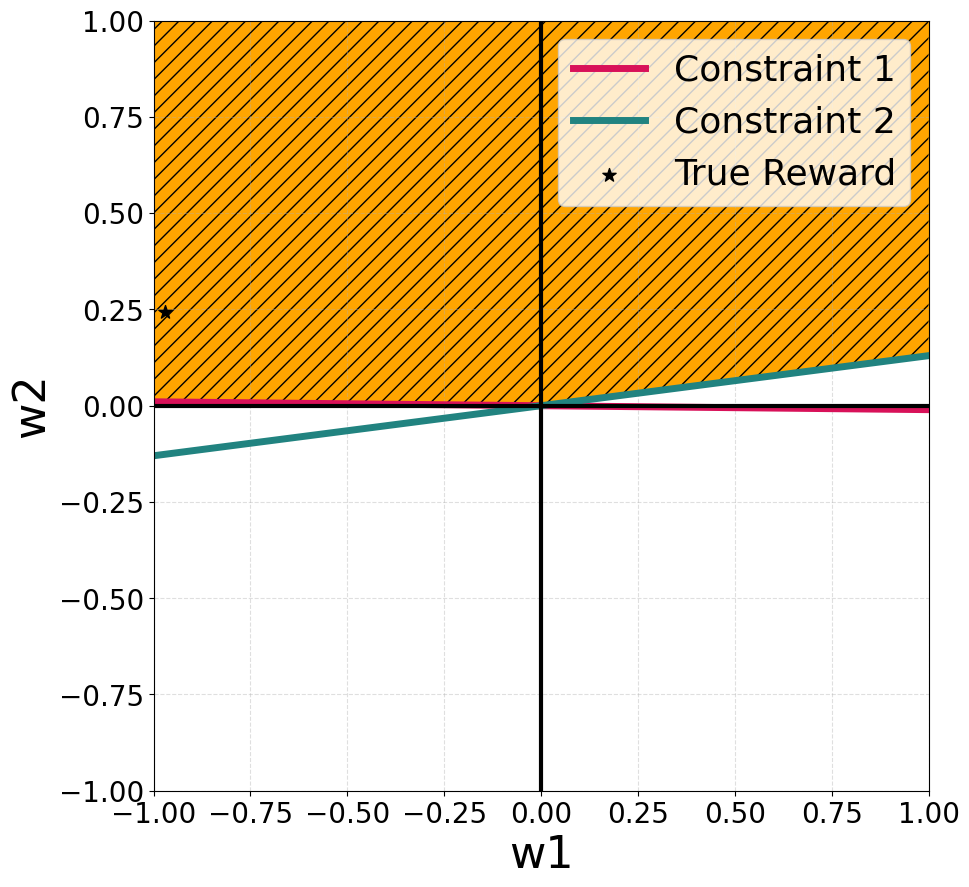

In [27]:
xs = [list(i) for i in non_redundant_vecs_demonstration]

# Plot setup
plt.figure(figsize=(10, 10))
num_constraints = len(xs)
colormap = cm.get_cmap('tab10', num_constraints)
#colors = [colormap(i) for i in range(num_constraints)]

colors = ["#d81159", "#218380"]

# True reward point
# true_reward = np.array([-0.9701425, 0.24253563])
true_reward = TRUE_REWARD
#Identify binding constraints (those where true_reward is on or near the plane)
tolerance = 1e-1  # Small tolerance for numerical precision
tolerance = 0.12  # Small tolerance for numerical precision
binding_indices = []
for i, point in enumerate(xs):

    # Check if true_reward satisfies the constraint approximately (point[0]*w1 + point[1]*w2 ≈ 0)
    constraint_value = point[0] * true_reward[0] + point[1] * true_reward[1]

    binding_indices.append(i)

#Limit to two binding constraints (if more are found, select the first two)
binding_indices = binding_indices

x1 = np.linspace(-1, 1, 4000)
for i in binding_indices:
    point = xs[i]
    if abs(point[1]) > 1e-10:  # Non-vertical line
        x2 = -(point[0] / point[1]) * x1
        plt.plot(x1, x2, color=colors[i], linestyle='-', linewidth=5, label=f'Constraint {i+1}')
    else:  # Vertical line
        plt.axvline(x=0, color=colors[i], linestyle='-', linewidth=5, label=f'Constraint {i+1}')

# Feasible region (still computed using all constraints for accuracy)
x1_grid, x2_grid = np.meshgrid(np.linspace(-1, 1, 8000), np.linspace(-1, 1, 8000))
feasible = np.ones_like(x1_grid, dtype=bool)
for i, point in enumerate(xs):
    if np.all(point == 0):
        continue
    constraint = point[0] * x1_grid + point[1] * x2_grid >= 0
    feasible &= constraint

# Plot feasible region with hatching
plt.contourf(x1_grid, x2_grid, feasible, levels=[0.5, 1], colors="orange", alpha=1, hatches=['//'])

plt.scatter(true_reward[0], true_reward[1],
            color='black',
            s=100,
            edgecolors='black',
            marker='*',
            zorder=5,
            label='True Reward')

# Axes and labels
plt.axhline(0, color='black', linewidth=3)
plt.axvline(0, color='black', linewidth=3)
plt.grid(True, linestyle="--", alpha=0.4)
plt.xlabel('w1', fontsize=32)
plt.ylabel('w2', fontsize=32)
plt.tick_params(axis='both', labelsize=20)
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.legend(fontsize=26)



#plt.savefig("estop_feasible_region_non_fixed_same_start.pdf", dpi=4000, bbox_inches='tight')
plt.savefig("demonstration_feasible_region_non_fixed_same_start.pdf", dpi=300, bbox_inches='tight')
plt.show()

In [28]:
print(f"Total feasible points: {np.sum(feasible)}")
print(f"Feasible region exists: {np.any(feasible)}")

Total feasible points: 30878369
Feasible region exists: True
